In [175]:
import os
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 6GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], 
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

In [27]:
PATH_1 = '../datasets/Anime_Sketch_Colorization_Pair'
train_path_1 = os.path.join(PATH_1, 'train')
test_path_1 = os.path.join(PATH_1, 'test')
print(train_path, test_path)

../datasets/Anime_Sketch_Colorization_Pair\train ../datasets/Anime_Sketch_Colorization_Pair\test


In [28]:
PATH_2 = '../datasets/auto painter sketch-only-sub'
train_path_2 = os.path.join(PATH_2, 'train')
test_path_2 = os.path.join(PATH_2, 'test')
print(train_path, test_path)

../datasets/Anime_Sketch_Colorization_Pair\train ../datasets/Anime_Sketch_Colorization_Pair\test


In [29]:
train_data = glob.glob(train_path_1 + '/*.png')
test_data = glob.glob(test_path_1 + '/*.png')
train_data += glob.glob(train_path_2 + '/*.png')
test_data += glob.glob(test_path_2 + '/*.png')

In [159]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
OUTPUT_CHANNELS = 3

In [50]:
def normalize(sketch, colored):
    sketch = (sketch / 127.5) - 1
    colored = (colored / 127.5) - 1
    
    return sketch, colored

In [51]:
def denormalize(image):
    image = (image + 1) * 127.5
    image = image.numpy()
    
    return image.astype(np.unit8)

In [107]:
def load_image(image_file, position=0):
    # The position is 0 if the sketch image is left and 1 if the sketch image is right.
    image = tf.io.read_file(image_file)
    image = tf.image.decode_image(image, expand_animations=False)
    
    w = tf.shape(image)[1]
    
    w = w // 2
    
    left_image = image[:, :w, :]
    right_image = image[:, w:, :]
    
    left_image = tf.cast(left_image, tf.float32)
    right_image = tf.cast(right_image, tf.float32)
    
    if position == 0:
        return left_image, right_image
    else:
        return right_image, left_image

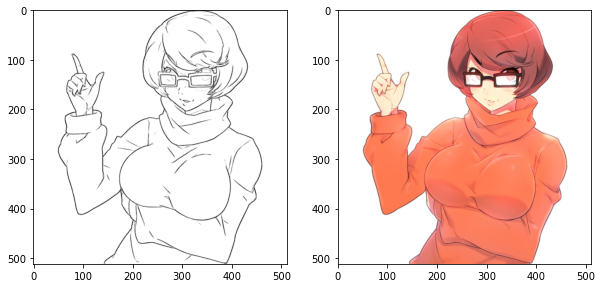

In [168]:
sketch, colored = load_image(train_data[0], position=1)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(sketch / 255.0)
plt.subplot(1, 2, 2)
plt.imshow(colored / 255.0)

In [101]:
def resize(sketch, colored, height=512, width=512):
    sketch = tf.image.resize(sketch, [height, width], method=tf.image.ResizeMethod.BICUBIC)
    colored = tf.image.resize(colored, [height, width], method=tf.image.ResizeMethod.BICUBIC)
    
    return sketch, colored

In [164]:
@tf.function
def augmentation(sketch, colored):
    # resizing to 512 x 512 x 3
    sketch, colored = resize(sketch, colored)
    
    if tf.random.uniform(()) > 0.5:
        # random flip
        sketch = tf.image.flip_left_right(sketch)
        colored = tf.image.flip_left_right(colored)
    
    return sketch, colored

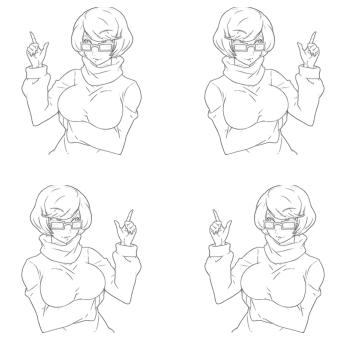

In [103]:
plt.figure(figsize=(6, 6))
for i in range(4):
    sketch_aug, colored_aug = augmentation(sketch, colored)
    plt.subplot(2, 2, i+1)
    plt.imshow(sketch_aug / 255.0)
    plt.axis('off')
plt.show()

In [108]:
def load_image_train(image_file, position=0):
    sketch, colored = load_image(image_file, position)
    sketch, colored = augmentation(sketch, colored)
    sketch, colored = normalize(sketch, colored)
    
    return sketch, colored

In [109]:
def load_image_test(image_file, position=0):
    sketch, colored = load_image(image_file, position)
    sketch, colored = resize(sketch, colored, IMG_HEIGHT, IMG_WIDTH)
    sketch, colored = normalize(sketch, colored)
    
    return sketch, colored

In [153]:
train_dataset = tf.data.Dataset.list_files(train_data)
train_dataset = train_dataset.map(lambda x: tf.py_function(func=load_image_train, inp=[x, 1], Tout=[tf.float32, tf.float32]), 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512, 3)
(1, 512, 512, 3)


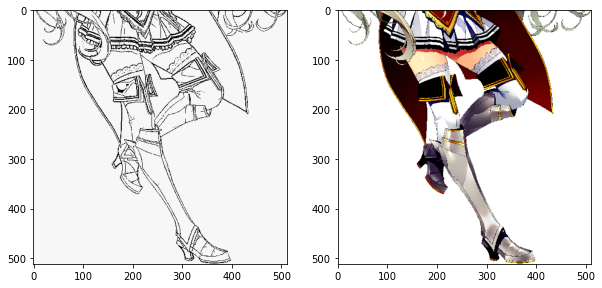

In [163]:
for i, j in train_dataset.take(1):
    print(i.shape)
    print(j.shape)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(i))
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(j))

In [179]:
def downsample(filters, size, apply_bn=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2,
                                      padding='same', 
                                      kernel_initializer=initializer, 
                                      use_bias=False))
    
    if apply_bn:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ReLU())
    
    return result

In [187]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(sketch, 0))
print(down_result.shape)

(1, 256, 256, 3)


In [188]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, 
                                               padding='same', 
                                               kernel_initializer=initializer,
                                               use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    
    return result

In [189]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 512, 512, 3)


In [191]:
def Generator():
    inputs = tf.keras.Input(shape=[512, 512, 3])
    
    down_stack = [
        downsample(64, 4, apply_bn=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, 
                                           padding='same', 
                                           kernel_initializer=initializer, 
                                           activation='tanh')
    
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [192]:
generator = Generator()

In [193]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 256, 256, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 128, 128, 128 131584      sequential_13[0][0]              
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 64, 64, 256)  525312      sequential_14[0][0]              
______________________________________________________________________________________________

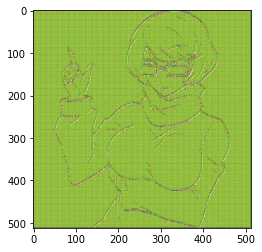

In [195]:
gen_output = generator(tf.expand_dims(sketch, axis=0), training=False)
plt.imshow(np.squeeze(gen_output) / 2 + 0.5)